In [5]:
from pymongo import MongoClient
from pathlib import Path
import os
from pprint import pprint
import nltk
import matplotlib.pyplot as plt
import pprint
import pywt

import os
import struct
import matplotlib
from scipy import signal
import scipy.fftpack
import numpy as np
import sys
import pymongo
import json

import numpy as np
from scipy.signal import butter, lfilter, freqz
import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
client = MongoClient('mongodb://localhost:27017')
testDb = client.testDb

patients = testDb.patients
sessions = testDb.sessions
reports = testDb.reports

In [7]:
def fileName(filePath):
    return (os.path.splitext(os.path.split(filePath)[1]))[0]

def fileExt(filePath):
    try:
        return (os.path.splitext(os.path.split(filePath)[1]))[1]
    except:
        return "Error"

In [29]:
class channel(object):
    def __init__(self,edfFile,label=None,transducer=None,dimensions=None,
                physMin=None,physMax=None,digMin=None,digMax=None,
                 preFilter=None,sampleRate=None,notes=None,channelIndex=None,byteLength=None):
        self.edfFile = edfFile
        self.label = str(label)
        self.sampleRate = int(sampleRate)
        self.transducer = str(transducer)
        self.dimensions = dimensions
        self.physMin = physMin
        self.physMax = physMax
        self.digMin = digMin
        self.digMax = digMax
        self.preFilter = preFilter
        self.notes  = notes
        self.channelIndex = int(channelIndex)
        self.byteLength = byteLength
        #self.indexStart = indexStart
    
    def __str__(self):
        if self.label==None:
            return "None"
        else:
            returnString = ("Label: "+str(self.label) + "\nSample Rate"+str(self.sampleRate)+
            "\nTransducer: "+str(self.transducer)+"\nDimensions: "+str(self.dimensions)+
            "\nphysMin: "+str(self.physMin)+"\nphysMax: "+str(self.physMax)+
            "\ndigMin: "+str(self.digMin) +"\ndigMax: "+str(self.digMax)+ "\npreFilter: "+str(self.preFilter)+
            "\nNotes: "+str(self.notes) + "\nChannelIndex: "+str(self.channelIndex) + "\nbyteLength: "+str(self.byteLength))
        return returnString
    
    def channelData(self,start,duration,channelNumber = 0,sensitivity = 1):
        '''
        Returns data points for desired area
        start: seconds from start of record
        duration: time  of record desired in seconds
        ##########This might be easier to do within original edf class
        Need to change to accomdate FLOATING POINTS !!!!!!!!!!!
        '''
        toReturn = []
        startByte = float(start) * self.sampleRate * 2
        '''
        print("TYPE START: ",type(start))
        print("channel.channelData Sample Rate: ",type(self.sampleRate))
        print("Start: ",start)
        print("START BYTE FROM CHANNEL DATA: ",startByte," Start: ",start," SampleRate: ",self.sampleRate)
        '''
        seekLocation = int(self.channelIndex + int(startByte))  #need to fix this --------------
        #print('Seek Location: ',seekLocation)
        numberOfBytes = int(self.sampleRate) * float(duration) #* 2
        try:
            numberOfBytes = int(numberOfBytes)
        except:
            return "ERROR in numberOfBytes"
        
        self.edfFile.edfRawData.seek(seekLocation)
        for i in range(numberOfBytes):
            try:
                value = struct.unpack('h',self.edfFile.edfRawData.read(2))[0]
                value = value*sensitivity    #Changed this from np.array(value)*sensitivity
                value -= channelNumber*20*sensitivity
            except:
                value = 'E'
            toReturn.append(value)
            #toReturn.append(struct.unpack('h',self.edfFile.edfRawData.read(2))) 
        return toReturn

    def allChannelData(self):
        toReturn = []
        self.edfFile.edfRawData.seek(self.channelIndex)
        for i in range(int(self.byteLength/2)):
            toReturn.append(struct.unpack('h',self.edfFile.edfRawData.read(2)))
        return toReturn
        
    def getLabel(self):
        return str(self.label)
    
    def getSampleRate(self):
        return self.sampleRate
    
    def getChannelIndex(self):
        return self.channelIndex
    
    def getTransducer(self):
        return self.transducer

    def getDimensions(self):
        return self.dimensions
    
    def getPhysMin(self):
        return float(self.physMin)
    
    def getPhysMax(self):
        return float(self.physMax)
    
    def getDigMin(self):
        return float(self.digMin)
    
    def getDigMax(self):
        return float(self.digMax)
    
    def getPreFilter(self):
        return self.preFilter
    
    def getNotes(self):
        return self.notes
    
    def getByteLength(self):
        return self.byteLength
    
class edfData(object):
    def __init__(self,fileId):
        self.fileId=fileId
        
    def __str__(self):
        return ("version: " + str(self.version) + "\nPatient Id: "+str(self.patientId) 
                + "\nrecordId" + str(self.recordId) + "\nStart Date: " + str(self.startTime)
                + "\nStart Time: " + str(self.startTime)
                + "\nheader Bytes: " + str(self.headerBytes) +"\nReserve Bytes: " +str(self.reservedBytes)
                + "\nNum Records :" + str(self.nRecords) + "\nNum Signals :" + str(self.nSignals) 
                + "\nDuration: "+ str(self.duration) + "\nFile Size: "+str(self.fileSize))
                
                
    def loadFile(self,filepath):
        self.filePath = filepath
        self.fileSize = os.path.getsize(filepath)
        self.edfRawData = open(filepath,'rb')
        
    def readBitsTest(self):
        self.edfRawData.seek(0)
        bits = self.edfRawData.read(10000)
        self.edfRawData.seek(0)
        print(self.edfRawData.read(10))
        print("Some Bits: "+str(bits))
        return bits
    
    def readSignalHeaderBits(self,bitsIn,nSignals,nBits):
            returnArray = []
            for x in range(nSignals):
                returnArray.append(bitsIn.read(nBits))
            return returnArray
        
    def returnChannelObjects(self):
        return self.channels
    
    def parseEdf(self):
        '''
            This function parses the edf file getting the values of 
            the header fields. It also creates a channel object with 
            information about each channel, including the eeg tracing data from each channel.
        '''
        #Header Fields
        self.version = str(self.edfRawData.read(8))
        self.patientId = str(self.edfRawData.read(80))
        self.recordId = str(self.edfRawData.read(80))
        self.startDate = str(self.edfRawData.read(8))
        self.startTime = str(self.edfRawData.read(8))
        self.headerBytes = int(self.edfRawData.read(8))
        self.reservedBytes = str(self.edfRawData.read(44))
        self.nRecords = int(self.edfRawData.read(8))
        self.duration = float(self.edfRawData.read(8))
        self.nSignals = int(self.edfRawData.read(4))
        
        #Create channel object for each channel
        self.channels = {}
        channelFields = ['labels','transducer','dimensions','physMin','physMax','digMin','digMax',
                        'preFilter','sampleRate','reservedNotes']
        self.channels['labels'] = self.readSignalHeaderBits(self.edfRawData,self.nSignals,16)
        self.channels['transducer'] = self.readSignalHeaderBits(self.edfRawData,self.nSignals,80)
        self.channels['dimensions'] = self.readSignalHeaderBits(self.edfRawData,self.nSignals,8)
        self.channels['physMin'] = self.readSignalHeaderBits(self.edfRawData,self.nSignals,8)
        self.channels['physMax'] = self.readSignalHeaderBits(self.edfRawData,self.nSignals,8)
        self.channels['digMin'] = self.readSignalHeaderBits(self.edfRawData,self.nSignals,8)
        self.channels['digMax'] = self.readSignalHeaderBits(self.edfRawData,self.nSignals,8)
        self.channels['preFilter'] = self.readSignalHeaderBits(self.edfRawData,self.nSignals,80)
        self.channels['sampleRate'] = self.readSignalHeaderBits(self.edfRawData,self.nSignals,8)
        self.channels['reservedNotes'] = self.readSignalHeaderBits(self.edfRawData,self.nSignals,32)
        
        self.channelObjects = []
        self.sampleRate = int(self.channels['sampleRate'][0])
        channelDataStart = self.headerBytes
        
    
        #This loop creates and adds channel objects to self.channelObjects
        for i in range(int(self.nSignals)):
            
            channelValues ={'filepath':self.filePath}
            byteLength = int(self.channels['sampleRate'][i])*self.nRecords     #*2
            channelIndex = channelDataStart
            channelDataStart +=byteLength
            
            for j in channelFields:
                try:
                    channelValues[j]=(self.channels[j][i])
                except:
                    channelValues[j] = None
            self.channelObjects.append(
                channel(self,channelValues['labels'],channelValues['transducer'],
                        channelValues['dimensions'],channelValues['physMin'],channelValues['physMax'],
                        channelValues['digMin'],channelValues['digMax'],channelValues['preFilter'],
                        channelValues['sampleRate'],channelValues['reservedNotes'],
                        channelDataStart,byteLength))  #Changed this channelIndex to channelDataStart
    
    
        self.channelSampleRates = channelValues['sampleRate'] 
        self.channelDigMax = channelValues['digMax']
        self.channelDigMin = channelValues['digMin']
        self.channelPhysMax = channelValues['physMax']
        self.channelPhysMin = channelValues['physMin']
            
    def data(self,start,duration):
        sampleData = []
        j = 0
        for x in self.channelObjects:
            sampleData.append([x.getLabel(),x.channelData(start,duration)])
            j+=1
        return sampleData
    
    def dataDictionary(self,start,duration):
        sampleData = {}
        j = 0
        #Returns dictionary with key being channel label, values being a dict [data,sampleRate,digMax,digMin,physMax,physMin]
        for x in self.channelObjects:
            sampleData[x.getLabel()]={'data':x.channelData(start,duration),'sampleRate':x.getSampleRate(),
                                     'digMax':x.getDigMax(),'digMin':x.getDigMin(),'physMin':x.getPhysMin(),
                                     'physMax':x.getPhysMax()}
            #print(x)
            j+=1
        return sampleData
    
    def dataForGraph(self,start,duration,sensitivity=1):
        sampleData = []
        j=0
        for x in self.channelObjects:
            sampleData.append([x.getLabel(),x.channelData(start,duration,j,sensitivity)])
            j+=1
        return sampleData
    
    def allData(self):
        '''
        Return[sampleRate,{channelData}]
        '''
        channelData = {}
        for x in self.channelObjects:
            channelData[str(x.getLabel())]=x.allChannelData()
        return[int(self.sampleRate),channelData]
            
            
    
    def patientId(self):
        return self.patientId
    
    def recordId(self):
        return self.recordId
    
    def startDate(self):
        return self.startDate
    
    def startTime(self):
        return self.startTime
    
    def headerBytes(self):
        return self.headerBytes
    
    def reservedBytes(self):
        return self.reservedBytes
    
    def duration(self):
        return self.duration
    
    def nRecords(self):
        return self.nRecords
    
    def numSignals(self):
        return self.nSignals
    
    def sampleRate(self):
        return int(self.sampleRate)

    def channelLabels(self):
        labels = []
        for channel in self.channelObjects:
            labels.append(channel.label())
        return labels
    
    def totalSamples(self):
        duration = int(self.sampleRate) * int(self.nRecords)
        return duration
    
    def testChannelPrint(self):
        print(self.channelObjects[2])

In [55]:
'''
Plotting Functions
'''

def plotEDF(edfObject,montageArray,startPlot,endPlot,maxIndexMarkers=False):
    edfDataDictionary = edfObject.dataDictionary(startPlot,endPlot)
    dataDictionaryKeys = list(edfDataDictionary.keys())
    
    for i,x in enumerate(montageArray):    
        channel1 = x[0]
        channel2 = x[1]
        channel1Label = dataDictionaryKeys[channel1]
        channel2Label = dataDictionaryKeys[channel2]
        
        channel1DigMax = edfDataDictionary[channel1Label]['digMax']
        channel1PhysMax = edfDataDictionary[channel1Label]['physMax']
        channel2DigMax = edfDataDictionary[channel1Label]['digMax']
        channel2PhysMax = edfDataDictionary[channel1Label]['physMax']
        
        channel1ScaleFactor = channel1PhysMax/channel1DigMax
        channel2ScaleFactor = channel2PhysMax/channel2DigMax
        
        input1Data = np.array(edfDataDictionary[channel1Label]['data']) * channel1ScaleFactor
        input2Data = np.array(edfDataDictionary[channel2Label]['data']) * channel2ScaleFactor
        
        plotData = input1Data - input2Data
        scaledAndMoved = plotData +(-i*600)
        channelAverageHeight = np.average(scaledAndMoved)
        
        channelsInMontage = len(montageArray)
        vLineHeight = 1/channelsInMontage
        
        if maxIndexMarkers == True:
            channelMax = max(plotData)
            maxIndex = list(plotData).index(channelMax)
            lineStart = 1-((i+2)*(vLineHeight))
            lineEnd = 1-(i*vLineHeight)
            plt.text(maxIndex,channelAverageHeight+60,("Index: "+str(maxIndex)+" Value: "+str(channelMax)))
            #plt.axes().axvline(maxIndex,i*vLineHeight,(i+1)*vLineHeight).set_color('green') This one is if plots aren't started from the bottom
            plt.axes().axvline(maxIndex,lineStart,lineEnd).set_color('green')

        #plt.text(maxIndex,channelAverageHeight+60,("Channel: ",str(x)," Max Index: ",str(maxIndex)))
        plt.text(0,channelAverageHeight+60,(str(channel1Label)+" - "+str(channel2Label)))
        plt.plot(scaledAndMoved)

    plt.show()
    

In [56]:
'''
Global Variables
'''

longBipolarMontage = [[0,10],[10,12],[12,14],[14,8],[0,2],[2,4],[4,6],[6,8],
                      [18,19],[19,20],[0,3],[3,4],[4,7],[7,9],[1,11],[11,13],[13,15],[15,9]] 
#adjacentE
adjacentElectrodeArray = [[0,1,4,5],[2,6,3,7],[10,11,14,15],[12,11,13,17]] 

#Contains Many Spikes
trainingFile1 ='/Users/taylorsomma/Desktop/capstone/v1.2.0/eval/01_tcp_ar/00009842/s001_2013_04_01/00009842_s001_t000.edf'

trainingEDF1 = edfData(1)
trainingEDF1.loadFile(trainingFile1)
trainingEDF1.parseEdf()
print(trainingEDF1)


version: b'0       '
Patient Id: b'00009842                                                                        '
recordIdb'Startdate 01-APR-2013 00009842_s001                                             '
Start Date: b'14.17.46'
Start Time: b'14.17.46'
header Bytes: 9472
Reserve Bytes: b'EDF                                         '
Num Records :1568
Num Signals :36
Duration: 1.0
File Size: 25890880


0


/Applications/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


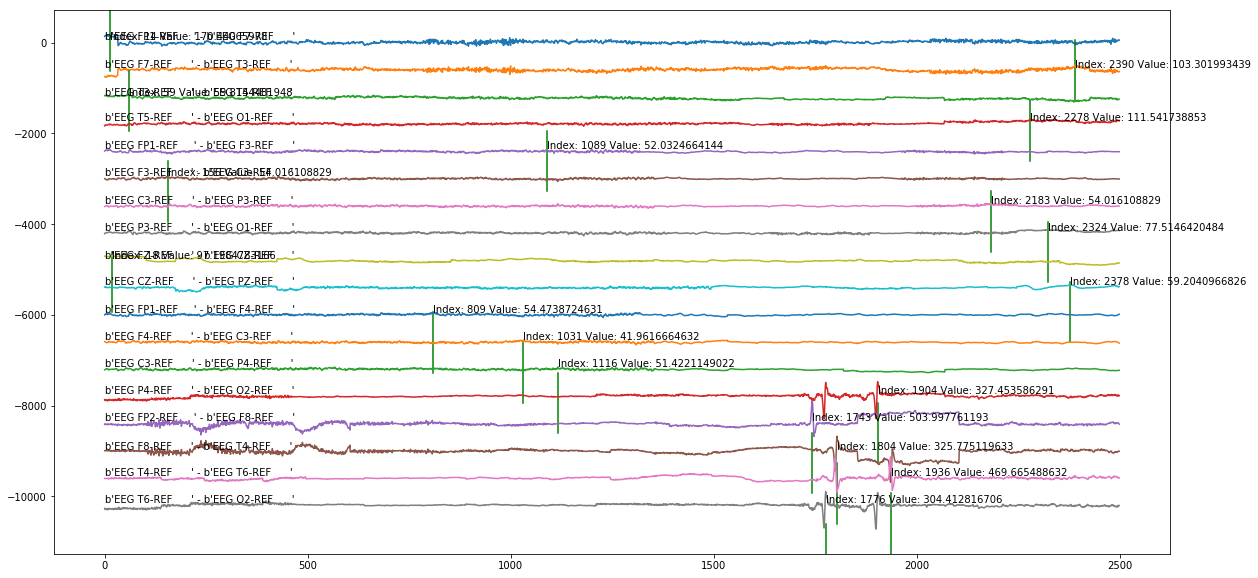

KeyboardInterrupt: 

In [57]:
keepPlotting = 1
while keepPlotting != -1:
    keepPlotting = input()
    plotStart = int(keepPlotting)
    plotEnd = int(plotStart+10)
    plt.figure(figsize=(20,10))
    plotEDF(trainingEDF1,longBipolarMontage,plotStart,plotEnd,True)

In [ ]:
def getChangeArray(inputArray):
    newArray =[]
    for i in range(len(inputArray)):
        if i==0:
            pass
        newArray.append(inputArray[i]-inputArray[i-1])
    return newArray

def movingAverage(inputArray,avgNum):
    newArray = []
    for i in range(len(inputArray)):
        if i<avgNum:
            pass
        newArray.append(np.average(inputArray[i-(avgNum):i]))
    return newArray

def returnVariation(eegData,width,sampleRate):
    #Looks for greatest change over the specified width in the signal
    #width is samples to 
    v1 = eegData[0]
    totalChange = 0 
    maxChange = 0
    maxIndex = 0
    dataLength = len(eegData)
    for i in range(dataLength-width):
        currentChange = 0
        for j in range(width-1):
            currentChange += eegData[j+i]-eegData[j+i+1]
             
        if abs(currentChange) > abs(maxChange):
            maxChange = currentChange
            maxIndex = i
        #print(currentChange)
        currentChange = 0
        
    msTime = maxIndex/sampleRate
    #print("Max Change: ",maxChange," Max Index: ",maxIndex," Max Time: ",msTime)
    return [maxChange,maxIndex,msTime]

In [ ]:
def lookForChannelSpikes(data,sampleRate,stepSize,searchSize,ampThreshold,ptpThreshold):
    '''
    data should already be scaled 
    stepSize in samples   If step size isn't small enough then some spikes could be missed if they are on the edge of the sample
    searchSize in seconds
    returns: array of possible spike indices
    '''
    dataLength = len(data)
    print("Data Length: ",dataLength)
    searchSamples = searchSize * sampleRate
    searchNumber = dataLength/stepSize
    endSampleLag = searchSamples/stepSize
    possibleSpikeArray = []
    possibleSpikeArrayIndices = []
    for x in range(int(searchNumber)-int(endSampleLag)):
        #print(x)
        startIndex = x*stepSize
        endIndex = x*stepSize+searchSamples
        #print("start index: ",startIndex)
        #print("end index: ",endIndex)
        currentData = data[int(startIndex):int(endIndex)]
        currentMax = np.amax(np.absolute(currentData))
        if currentMax>ampThreshold:
            freqs, pxx = scipy.signal.periodogram(currentData, sampleRate)
            try:
                maxIndex = list(currentData).index(currentMax)
                #print("In Try")
            except:
                maxIndex = list(currentData).index(0-currentMax)
                #print("Int EXcept")
            maxIndex = maxIndex + startIndex
            if maxIndex in possibleSpikeArrayIndices:
                #print("Adding maxIndex")
                pass
            else:
                possibleSpikeArrayIndices.append(maxIndex)
                possibleSpikeArray.append([maxIndex,[freqs,pxx]])
    return possibleSpikeArray

def checkQuadrants(channelDict,adjacencyArray):
    spikeCandidates = []
    for adjacency in adjacencyArray:
        spikesInQuadrant = []
        for channelIndex in adjacency:
            spikeIndexes = channelDict[channelIndex]
            for spike in spikeIndexes:
                spikesInQuadrant.append(spike[0])
            print(spikesInQuadrant[0:10])
            spikeCandidates.append(spikesInQuadrant.sort())
    return spikeCandidates

def removeIsolatedSpikes(indexArray,sampleRate,latencyAllowed):
    '''
    indexArray: Array of indices of possible spikes in a quadrant
    sampleRate: sampleRate of data
    latencyAllowed: distance between possible spikes in msec
    '''
    latencySamples = (latencyAllowed/1000)*sampleRate
    returnArray = []
    indexLength = len(indexArray)
    removed = 0
    for i, x in enumerate(indexArray):
        sampleDistance = 1
        if i < indexLength-1 and i>0:
            if x<indexArray[i-1]+latencySamples or x>indexArray[i+1]-latencySamples:
                if x>600:
                    returnArray.append(x)
            else:
                removed+=1
    print("Removed: ",removed)
    return returnArray

def removeCloseSpikes(indexArray,sampleRate,minDistanceBetweenSpikes):
    '''
    indexArray: Array of indices of possible spikes in a quadrant
    sampleRate: sampleRate of data
    latencyAllowed: distance between possible spikes in msec
    '''
    returnArray = []
    indexLength = len(indexArray)
    removed = 0
    addThisSpike = True
    for i, x in enumerate(indexArray):
        if i==0:
            returnArray.append(x)
            pass
        for y in returnArray:
            if abs(x-y)<minDistanceBetweenSpikes:
                addThisSpike = False
        if addThisSpike==True:
            returnArray.append(x)
        else:
            addThisSpike=True
            removed+=1

def checkInput():
    a = input()
    a = int(a)
    if int(a)==0 or int(a)==1:
        return int(a)
    checkInput()